Trial 12 Complete [00h 00m 17s]
val_loss: 0.0005227385554462671

Best val_loss So Far: 0.000413605070207268
Total elapsed time: 00h 06m 49s
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step

/home/rangga/metopen-1/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
BEST MODEL → RMSE: 2.96 points, SMAPE: 2.97%


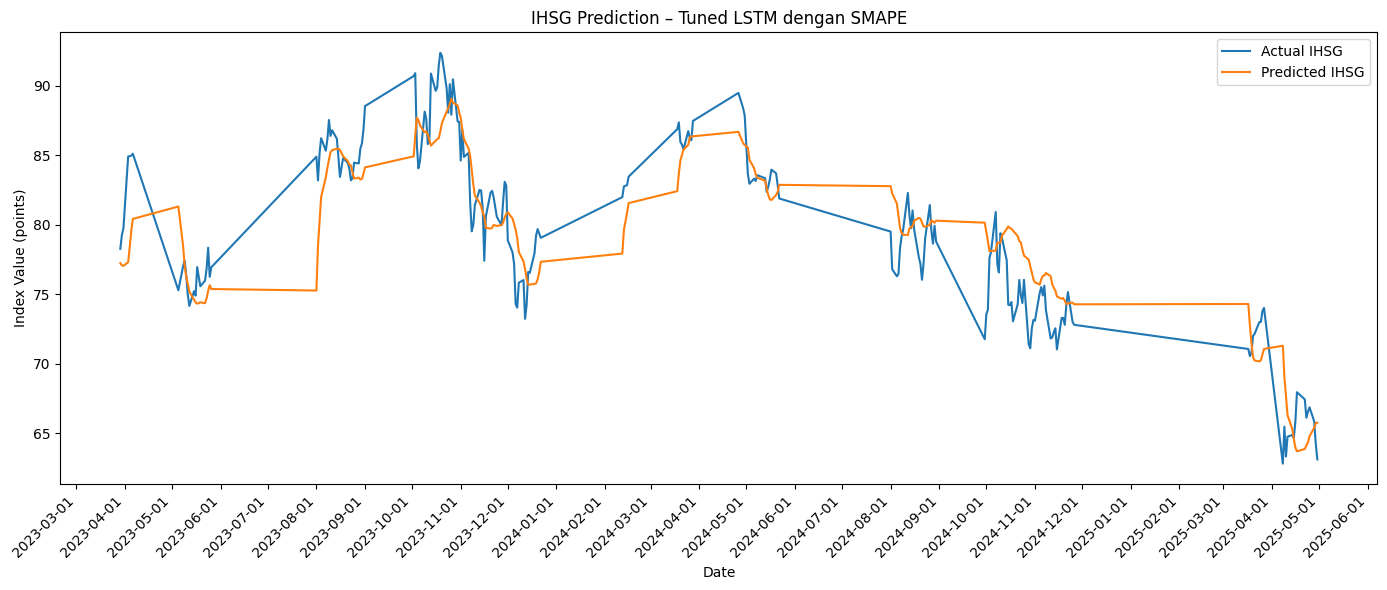

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import Huber
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

import random
import keras_tuner as kt

# reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# ----------------------------
# 1. DOWNLOAD & PREPARE DATA
# ----------------------------
tickers = ['^JKSE','^GSPC','BZ=F','USDIDR=X']
raw = yf.download(tickers,
                  start='2012-01-01',
                  end='2025-05-01',
                  auto_adjust=True)['Close']
raw.columns = ['IHSG','SP500','Brent','USDIDR']

df = raw.copy()
# Moving averages
for w in (5,10,20):
    df[f'MA_{w}'] = df['IHSG'].rolling(w).mean()

# RSI 14
delta = df['IHSG'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain/avg_loss
df['RSI_14'] = 100 - (100/(1+rs))

# MACD
ema12 = df['IHSG'].ewm(span=12, adjust=False).mean()
ema26 = df['IHSG'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

df.dropna(inplace=True)

# ----------------------------
# 2. SCALE & SEQUENCE UTILITY
# ----------------------------
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df.values)

SEQ_LEN = 60
def create_sequences(data, seq_len=SEQ_LEN):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i,0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ----------------------------
# 3. DEFINE CUSTOM SMAPE
# ----------------------------
def smape(y_true, y_pred):
    """
    Symmetric Mean Absolute Percentage Error
    SMAPE = mean( 2 * |y_pred - y_true| / (|y_true| + |y_pred| + eps) )
    """
    diff = K.abs(y_pred - y_true)
    denom = (K.abs(y_true) + K.abs(y_pred) + K.epsilon())
    return K.mean(2.0 * diff / denom, axis=-1)

# ----------------------------
# 4. DEFINE HYPERMODEL
# ----------------------------
def build_hyper_model(hp):
    model = Sequential()
    # First LSTM layer
    model.add(LSTM(
        units=hp.Int('units1', 32, 128, step=32),
        return_sequences=hp.Boolean('return_seq'),
        input_shape=(SEQ_LEN, df.shape[1])
    ))
    model.add(Dropout(hp.Float('drop1', 0.1, 0.5, step=0.1)))
    if hp.Boolean('second_lstm'):
        model.add(LSTM(
            units=hp.Int('units2', 32, 128, step=32)
        ))
        model.add(Dropout(hp.Float('drop2', 0.1, 0.5, step=0.1)))
    model.add(Dense(
        units=hp.Int('dense_units', 8, 64, step=8),
        activation='relu'
    ))
    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('lr', 1e-4, 1e-2, sampling='LOG')
        ),
        loss=Huber(),
        metrics=[smape]
    )
    return model

tuner = kt.RandomSearch(
    build_hyper_model,
    objective='val_loss',
    max_trials=12,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='ihsg_lstm_smape'
)

# ----------------------------
# 5. RUN TUNER
# ----------------------------
early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tuner.search(
    X_train, y_train,
    epochs=60,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[early],
    verbose=1
)

best_model = tuner.get_best_models(num_models=1)[0]

# ----------------------------
# 6. EVALUATE & PRINT METRICS
# ----------------------------
pred_scaled = best_model.predict(X_test)

def inv_scale(vals):
    buf = np.zeros((len(vals), df.shape[1]))
    buf[:,0] = vals
    return scaler.inverse_transform(buf)[:,0]

true = inv_scale(y_test)
pred = inv_scale(pred_scaled.flatten())

rmse = np.sqrt(mean_squared_error(true, pred))
# hitung SMAPE sekali lagi di luar
smape_score = np.mean(2 * np.abs(pred - true) / (np.abs(true) + np.abs(pred) + 1e-8)) * 100

print(f'BEST MODEL → RMSE: {rmse:.2f} points, SMAPE: {smape_score:.2f}%')

# ----------------------------
# 7. PLOT HASIL
# ----------------------------
dates = df.index[SEQ_LEN + split:]

plt.figure(figsize=(14,6))
plt.plot(dates, true,  label='Actual IHSG')
plt.plot(dates, pred,  label='Predicted IHSG')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45, ha='right')
plt.title('IHSG Prediction – Tuned LSTM dengan SMAPE')
plt.xlabel('Date')
plt.ylabel('Index Value (points)')
plt.legend()
plt.tight_layout()
plt.show()


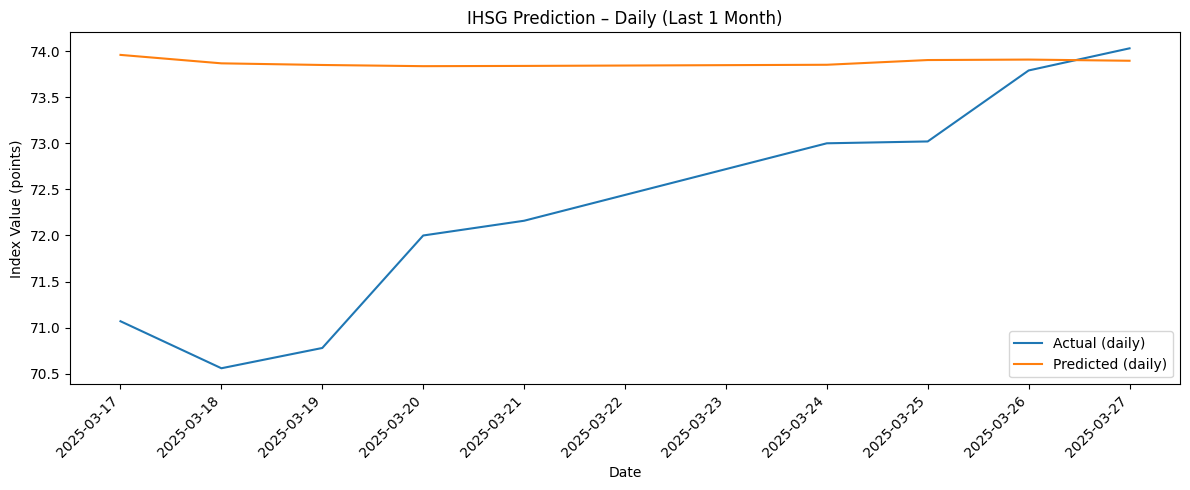

In [47]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Filter data 1 bulan terakhir dari tanggal maksimum
end_date = results.index.max()
start_date = end_date - pd.DateOffset(days=30)
last_month = results.loc[start_date:end_date]

# 2. Plot
plt.figure(figsize=(12,5))
plt.plot(last_month.index, last_month['Actual'],   label='Actual (daily)')
plt.plot(last_month.index, last_month['Predicted'],label='Predicted (daily)')

# Format tanggal harian
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')

plt.title('IHSG Prediction – Daily (Last 1 Month)')
plt.xlabel('Date')
plt.ylabel('Index Value (points)')
plt.legend()
plt.tight_layout()
plt.show()



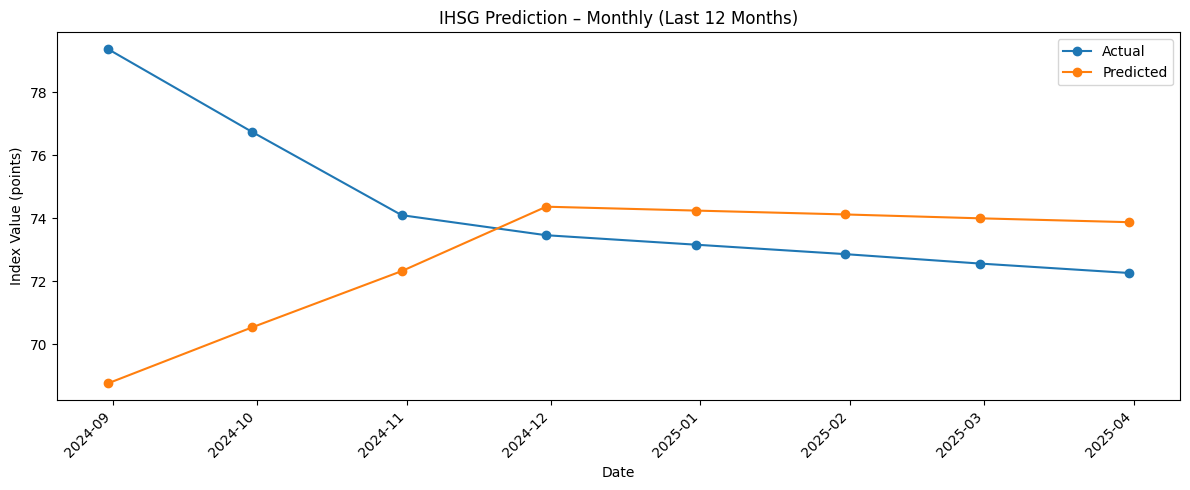

In [46]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Resample bulanan rata-rata
monthly = results.resample('ME').mean()

# 2. Buat index 12 bulan penuh hingga bulan terakhir
idx_full = pd.date_range(
    start=monthly.index.max() - pd.DateOffset(months=11),
    end=monthly.index.max(),
    freq='ME'
)

# 3. Reindex dan isi nilai yang hilang (interpolasi) - tanpa inplace chaining
monthly = monthly.reindex(idx_full)
monthly['Actual'] = monthly['Actual'].interpolate()
monthly['Predicted'] = monthly['Predicted'].interpolate()

# 4. Plot ulang
plt.figure(figsize=(12,5))
plt.plot(monthly.index, monthly['Actual'],   marker='o', label='Actual')
plt.plot(monthly.index, monthly['Predicted'],marker='o', label='Predicted')
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))      
plt.xticks(rotation=45, ha='right')
plt.title('IHSG Prediction – Monthly (Last 12 Months)')
plt.xlabel('Date')
plt.ylabel('Index Value (points)')
plt.legend()
plt.tight_layout()
plt.show()
